# Imports

In [3]:
import torch
import torch.nn as nn
torch.no_grad()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from typing import Callable

# RNN

Define a continuous time RNN by the discretisation of:
$$
\tau \dot{x} = -x + W_{rec} f(x) + W_{in} u + \eta \\

x(t + \Delta t) = x(t) + \alpha (-x(t) + W_{rec} f(x(t)) + W_{in} u(t) + \eta)
$$

where:
* $x \in \R^N$ are network states
* $u \in \R^{N_{in}}$ are inputs
* $\alpha = \frac{\tau}{\Delta t}$ is the discretised step size
* $\eta \sim N(0, \sigma^2)$ is noise added to states at each timestep
* $W_{rec} \in \R^{(N \times N)} \sim N(0, \frac{g^2}{N})$ defines the recurrency between hidden units
* $W_{in} \in \R^{(N \times N_{in})} \sim N(0, 1)$ defines the feed-forward weights from inputs to hidden units

By default:
* $x(0) = 0$
* $g = 0.9$
* $\alpha = 0.1$
* $f(x) = ReTanh(x) = \max(0, \tanh(x))$
* $u(t) = [\sin(\theta_1), \cos(\theta_1), \sin(\theta_2), \cos(\theta_2)]$ for $t=0$ and $0$ otherwise
* $\sigma = 0.1$

In [4]:
class Net(nn.Module):
    """
    Parameters:
    - n_inputs: int, number of input units (N_in above)
    - n_units: int, number of recurrent units (N above)
    - g: float, recurrent weight scaling factor
    - activation_func: activation function (f above; default is ReTanh)
    
    """
    def __init__(self, n_inputs, n_units, g: float=0.9, activation_func: Callable[[torch.Tensor], torch.Tensor]=lambda x: torch.max(torch.zeros_like(x), torch.tanh(x))):
        self.n_inputs, self.n_units, self.g, self.activation_func = n_inputs, n_units, g, activation_func
        super(Net, self).__init__()

        self.W_in = nn.Linear(n_inputs, n_units, bias=True).requires_grad_(False)

        W_rec_weight = torch.normal(mean=0.0, std=g/np.sqrt(n_units), size=(n_units, n_units))
        self.W_rec = nn.Linear(n_units, n_units, bias=False)
        self.W_rec.weight = nn.Parameter(W_rec_weight, requires_grad=False)

        self.x_0 = torch.zeros(n_units)

    """
    forward
    Forward pass of the RNN

    Parameters:
    - u: torch.Tensor, input tensor of shape (n_trials, n_inputs)
    - n_timesteps: int, number of timesteps to simulate
    - n_input_times: int, number of timesteps to present the input (otherwise input is zero)
    - alpha: float, discrete time step size, alpha = tau/dt
    - noise_std: float, standard deviation of Gaussian noise added to states at each timestep
    - keep_times: list of int, timesteps to keep in the output tensor (default is all)
    
    """
    def forward(self, u, n_timesteps=100, n_input_times=1, alpha=0.1, noise_std=0, keep_times=None):
        assert len(u.shape)==2, "Input tensor must have shape (n_trials, n_inputs)"
        assert u.shape[1]==self.n_inputs, "Input tensor must have shape (n_trials, n_inputs)"
        n_trials = u.shape[0]

        X = [self.x_0.reshape(1, -1).repeat(n_trials, 1)]

        if keep_times is None:
            keep_times = range(n_timesteps)

        for t in range(n_timesteps+1):
            x_t = X.pop()
            u_t = u if t<n_input_times else torch.zeros_like(u)
            noise_t = torch.normal(mean=0.0, std=noise_std, size=(n_trials, self.n_units))

            # Continuous-Time RNN Update Funcion:
            x_next = x_t + (alpha) * (-x_t + self.W_rec(self.activation_func(x_t)) + self.W_in(u_t) + noise_t)

            if t in keep_times:
                X.append(x_next)
            elif t>max(keep_times):
                break
            
            if t < n_timesteps:
                X.append(x_next)

        states = torch.stack(X, dim=1)

        return states

# Metric Calculation

Estimate by euler steps $\forall (\theta_1, \theta_2, t) \in [0, \frac{2pi}{k}, \dots, 2\pi] \times [0, \frac{2pi}{k}, \dots, 2\pi] \times [0, 1, \dots, T]$:
$$
\phi(\theta_1, \theta_2, t) = x(0) + \int_0^t \dot{x}(\theta_1, \theta_2, t) dt \\

\phi(\theta_1, \theta_2, t) \approx x(0) + \alpha \Sigma_{i=0}^{t-1} ( -x(i) + W_{rec} f(x(i)) + W_{in} u(i) )
$$

Also compute $\phi(\theta_1 + \Delta \theta, \theta_2, t)$ and $\phi(\theta_1, \theta_2 +\Delta \theta, t)$, so as to estimate by finite differences:
$$
\frac{\partial \phi}{\partial \theta_1}(\theta_1, \theta_2, t) = \frac{\phi(\theta_1 + \Delta \theta, \theta_2, t) - \phi(\theta, \theta_2, t)}{\Delta \theta} \\

\frac{\partial \phi}{\partial \theta_2}(\theta_1, \theta_2, t) = \frac{\phi(\theta_1, \theta_2 + \Delta \theta, t) - \phi(\theta, \theta_2, t)}{\Delta \theta}
$$

The basis of the tangent space at $\phi(\theta_1, \theta_2)$ is spanned by $\frac{\partial \phi}{\partial \theta_1}$ and $\frac{\partial \phi}{\partial \theta_2}$

The metric is defined by
$$
    [\frac{\partial \phi}{\partial \theta_1} \frac{\partial \phi}{\partial \theta_2}]^T [\frac{\partial \phi}{\partial \theta_1} \frac{\partial \phi}{\partial \theta_2}] \in \R^{(2 \times 2)}
$$

This is expanded into a $2k \times 2k$ matrix $M$ such that
$$
M_{ij} = \frac{\partial \phi}{\partial \theta_{1_i}} \cdot \frac{\partial \phi}{\partial \theta_{1_j}}; i, j < k \\
M_{ij} = \frac{\partial \phi}{\partial \theta_{1_i}} \cdot \frac{\partial \phi}{\partial \theta_{1_{j-k}}}; i < k, j >= k  \\
M_{ij} = \frac{\partial \phi}{\partial \theta_{1_{i-k}}} \cdot \frac{\partial \phi}{\partial \theta_{1_j}}; i >= k, j < k \\
M_{ij} = \frac{\partial \phi}{\partial \theta_{1_{i-k}}} \cdot \frac{\partial \phi}{\partial \theta_{1_{j-k}}}; i, j >= k \\
$$

In [5]:
import math

def coeff(n):
    P = np.linspace(-n, n, 2*n+1, dtype=np.int32)
    C = np.full((len(P),), np.nan)
    for i, p in enumerate(P):
        if p==0:
            continue
        c = ((-1)**(np.abs(p)+1) * math.factorial(n)**2) / (p * math.factorial(n-p) * math.factorial(n+p))
        C[i] = c

    return P, C

"""
dphi_dtheta
Compute the derivative of the RNN state over time with respect to the parameters theta_1 and theta_2

Parameters:
- theta_1_vals: torch.tensor, values of the first parameter theta_1 (1D tensor)
- theta_2_vals: torch.tensor, values of the second parameter theta_2 (1D tensor)
- net: Net, continuous-time RNN model to compute the state
- input_func: Callable[[torch.tensor, torch.tensor], torch.tensor], function to construct the input to the RNN given theta_1 and theta_2
- d_theta: float, small perturbation to theta_1/theta_1 for finite difference derivative
- n_timesteps, alpha, noise_std, n_input_times: parameters for the RNN model forward pass
- alpha: float, discrete time step size, alpha = tau/dt
- noise_std: float, standard deviation of Gaussian noise added to states at each timestep
- n_input_times: int, number of timesteps to present the input (otherwise input is zero)
- select_t: list of int, timesteps to keep in the output tensor (default is all)

"""
def get_dphi_dtheta(theta_1_vals: torch.tensor, theta_2_vals: torch.tensor, net: Net, input_func: Callable[[torch.tensor, torch.tensor], torch.tensor], d_theta=1e-6, order=1, n_timesteps=100, alpha=0.1, noise_std=0, n_input_times=1, select_t=None):
    assert len(theta_1_vals.shape)==1, "theta_1_vals must be a 1D tensor"
    assert len(theta_2_vals.shape)==1, "theta_2_vals must be a 1D tensor"
    assert theta_1_vals.shape[0]==theta_2_vals.shape[0], "theta_1_vals and theta_2_vals must have the same length"

    theta_1, theta_2 = torch.meshgrid(theta_1_vals, theta_2_vals)
    theta_1, theta_2 = theta_1.flatten(), theta_2.flatten()

    if select_t is None:
        select_t = list(range(n_timesteps))

    dphi_dtheta_1 = torch.zeros((len(theta_1_vals), len(theta_2_vals), len(select_t), net.n_units))
    dphi_dtheta_2 = torch.zeros((len(theta_1_vals), len(theta_2_vals), len(select_t), net.n_units))

    P, C = coeff(order)
    for p, c in zip(P, C):
        if np.isnan(c):
            continue
        phi_dtheta_1_theta_2 = net(input_func(theta_1 + p*d_theta, theta_2), alpha=alpha, noise_std=noise_std, n_timesteps=n_timesteps, n_input_times=n_input_times, keep_times=select_t)     # (n_trials, n_timesteps, n_units)
        phi_dtheta_1_theta_2 = phi_dtheta_1_theta_2.reshape(len(theta_1_vals), len(theta_2_vals), len(select_t), -1)                                                                            # (n_theta_1, n_theta_2, n_timesteps, n_units)
        dphi_dtheta_1 += (c/d_theta) * phi_dtheta_1_theta_2

        phi_theta_1_dtheta_2 = net(input_func(theta_1, theta_2 + p*d_theta), alpha=alpha, noise_std=noise_std, n_timesteps=n_timesteps, n_input_times=n_input_times, keep_times=select_t)     # (n_trials, n_timesteps, n_units)
        phi_theta_1_dtheta_2 = phi_theta_1_dtheta_2.reshape(len(theta_1_vals), len(theta_2_vals), len(select_t), -1)                                                                            # (n_theta_1, n_theta_2, n_timesteps, n_units)
        dphi_dtheta_2 += (c/d_theta) * phi_theta_1_dtheta_2
    
    dphi_dtheta_1 = dphi_dtheta_1.permute(2, 0, 1, 3)                                                                                                   # (n_timesteps, n_theta_1, n_theta_2, n_units)
    dphi_dtheta_2 = dphi_dtheta_2.permute(2, 0, 1, 3)                                                                                                   # (n_timesteps, n_theta_1, n_theta_2, n_units)

    return dphi_dtheta_1, dphi_dtheta_2

"""
metric
Compute the metric tensor from the derivative of the RNN state over time with respect to the parameters theta_1 and theta_2

Parameters:
- dphi_dtheta_1: torch.tensor, derivative of the RNN state over time with respect to the first parameter theta_1
- dphi_dtheta_2: torch.tensor, derivative of the RNN state over time with respect to the second parameter theta_2
"""
def get_metric(dphi_dtheta_1, dphi_dtheta_2):
    assert dphi_dtheta_1.shape==dphi_dtheta_2.shape, "dphi_dtheta_1 and dphi_dtheta_2 must have the same shape"
    assert len(dphi_dtheta_1.shape)==4, "dphi_dtheta_1 and dphi_dtheta_2 must be 4D tensors (n_timesteps, n_samples, n_samples, n_units)"
    n_timesteps, n_samples, _, n_units = dphi_dtheta_1.shape

    tangent_basis = torch.stack([dphi_dtheta_1, dphi_dtheta_2], dim=3)                                                                                  # (n_timesteps, n_samples, n_samples, 2, n_units)
    metric = torch.matmul(tangent_basis, tangent_basis.transpose(-1, -2))                                                                               # (n_timesteps, n_samples, n_samples, 2, 2)

    metric_expanded = torch.full((n_timesteps, 2*n_samples, 2*n_samples), np.nan)                                                                       # (n_timesteps, 2*n_samples, 2*n_samples)
    
    metric_expanded[:, :n_samples, :n_samples] = metric[:, :, :, 0, 0]
    metric_expanded[:, n_samples:, :n_samples] = metric[:, :, :, 1, 0]
    metric_expanded[:, :n_samples, n_samples:] = metric[:, :, :, 0, 1]
    metric_expanded[:, n_samples:, n_samples:] = metric[:, :, :, 1, 1]

    return metric_expanded


# Plotting

In [8]:
"""
clifford_input
Format input in 4D (clifford torus)
"""
def clifford_input(theta_1, theta_2):
    return torch.stack([torch.sin(theta_1), torch.cos(theta_1), torch.cos(theta_2), torch.sin(theta_2)], dim=1)

In [9]:
"""
standard_input
Format input in 3D (standard torus)
"""
def standard_input(theta_1, theta_2):
    return torch.stack([(1 + torch.cos(theta_2))*torch.sin(theta_1), (1+ torch.cos(theta_2))*torch.cos(theta_1), torch.sin(theta_2)], dim=1)


In [97]:
"""
Plot Parameters
"""
alpha = 0.01
d_theta = 1e-2
order = 4
n_samples = 30

N = 100
T = [0, 1, 10, 25, 50, 100, 150, 200, 250, 500]    
order = 4
g = [1, 2, 0.5]
n_input_times = 10

plot_var = g
plot_var_title = r'g'

In [98]:
"""
Compute metric for each value of G
"""
import gc

theta_1_vals, theta_2_vals = torch.linspace(0, 2*np.pi, n_samples), torch.linspace(0, 2*np.pi, n_samples)

all_metrics = []
for i, v in enumerate(plot_var):
    net = Net(n_inputs=4, n_units=N, g=v)

    dphi_dtheta_1, dphi_dtheta_2 = get_dphi_dtheta(theta_1_vals, theta_2_vals, net, clifford_input, n_timesteps=max(T)+1, alpha=alpha, noise_std=0, d_theta=d_theta, n_input_times=n_input_times, select_t=T, order=order)
    metric = get_metric(dphi_dtheta_1, dphi_dtheta_2)

    all_metrics.append(metric)

    gc.collect()

    print(fr"Finished {plot_var_title}={v}")

Finished g=1
Finished g=2
Finished g=0.5


Text(0.5, 0.98, 'Metric for Different Values of g, using:\n$N = 100 | g = [1, 2, 0.5] | \\Delta t=0.01\\tau | \\Delta \\theta = 1.0E-02$')

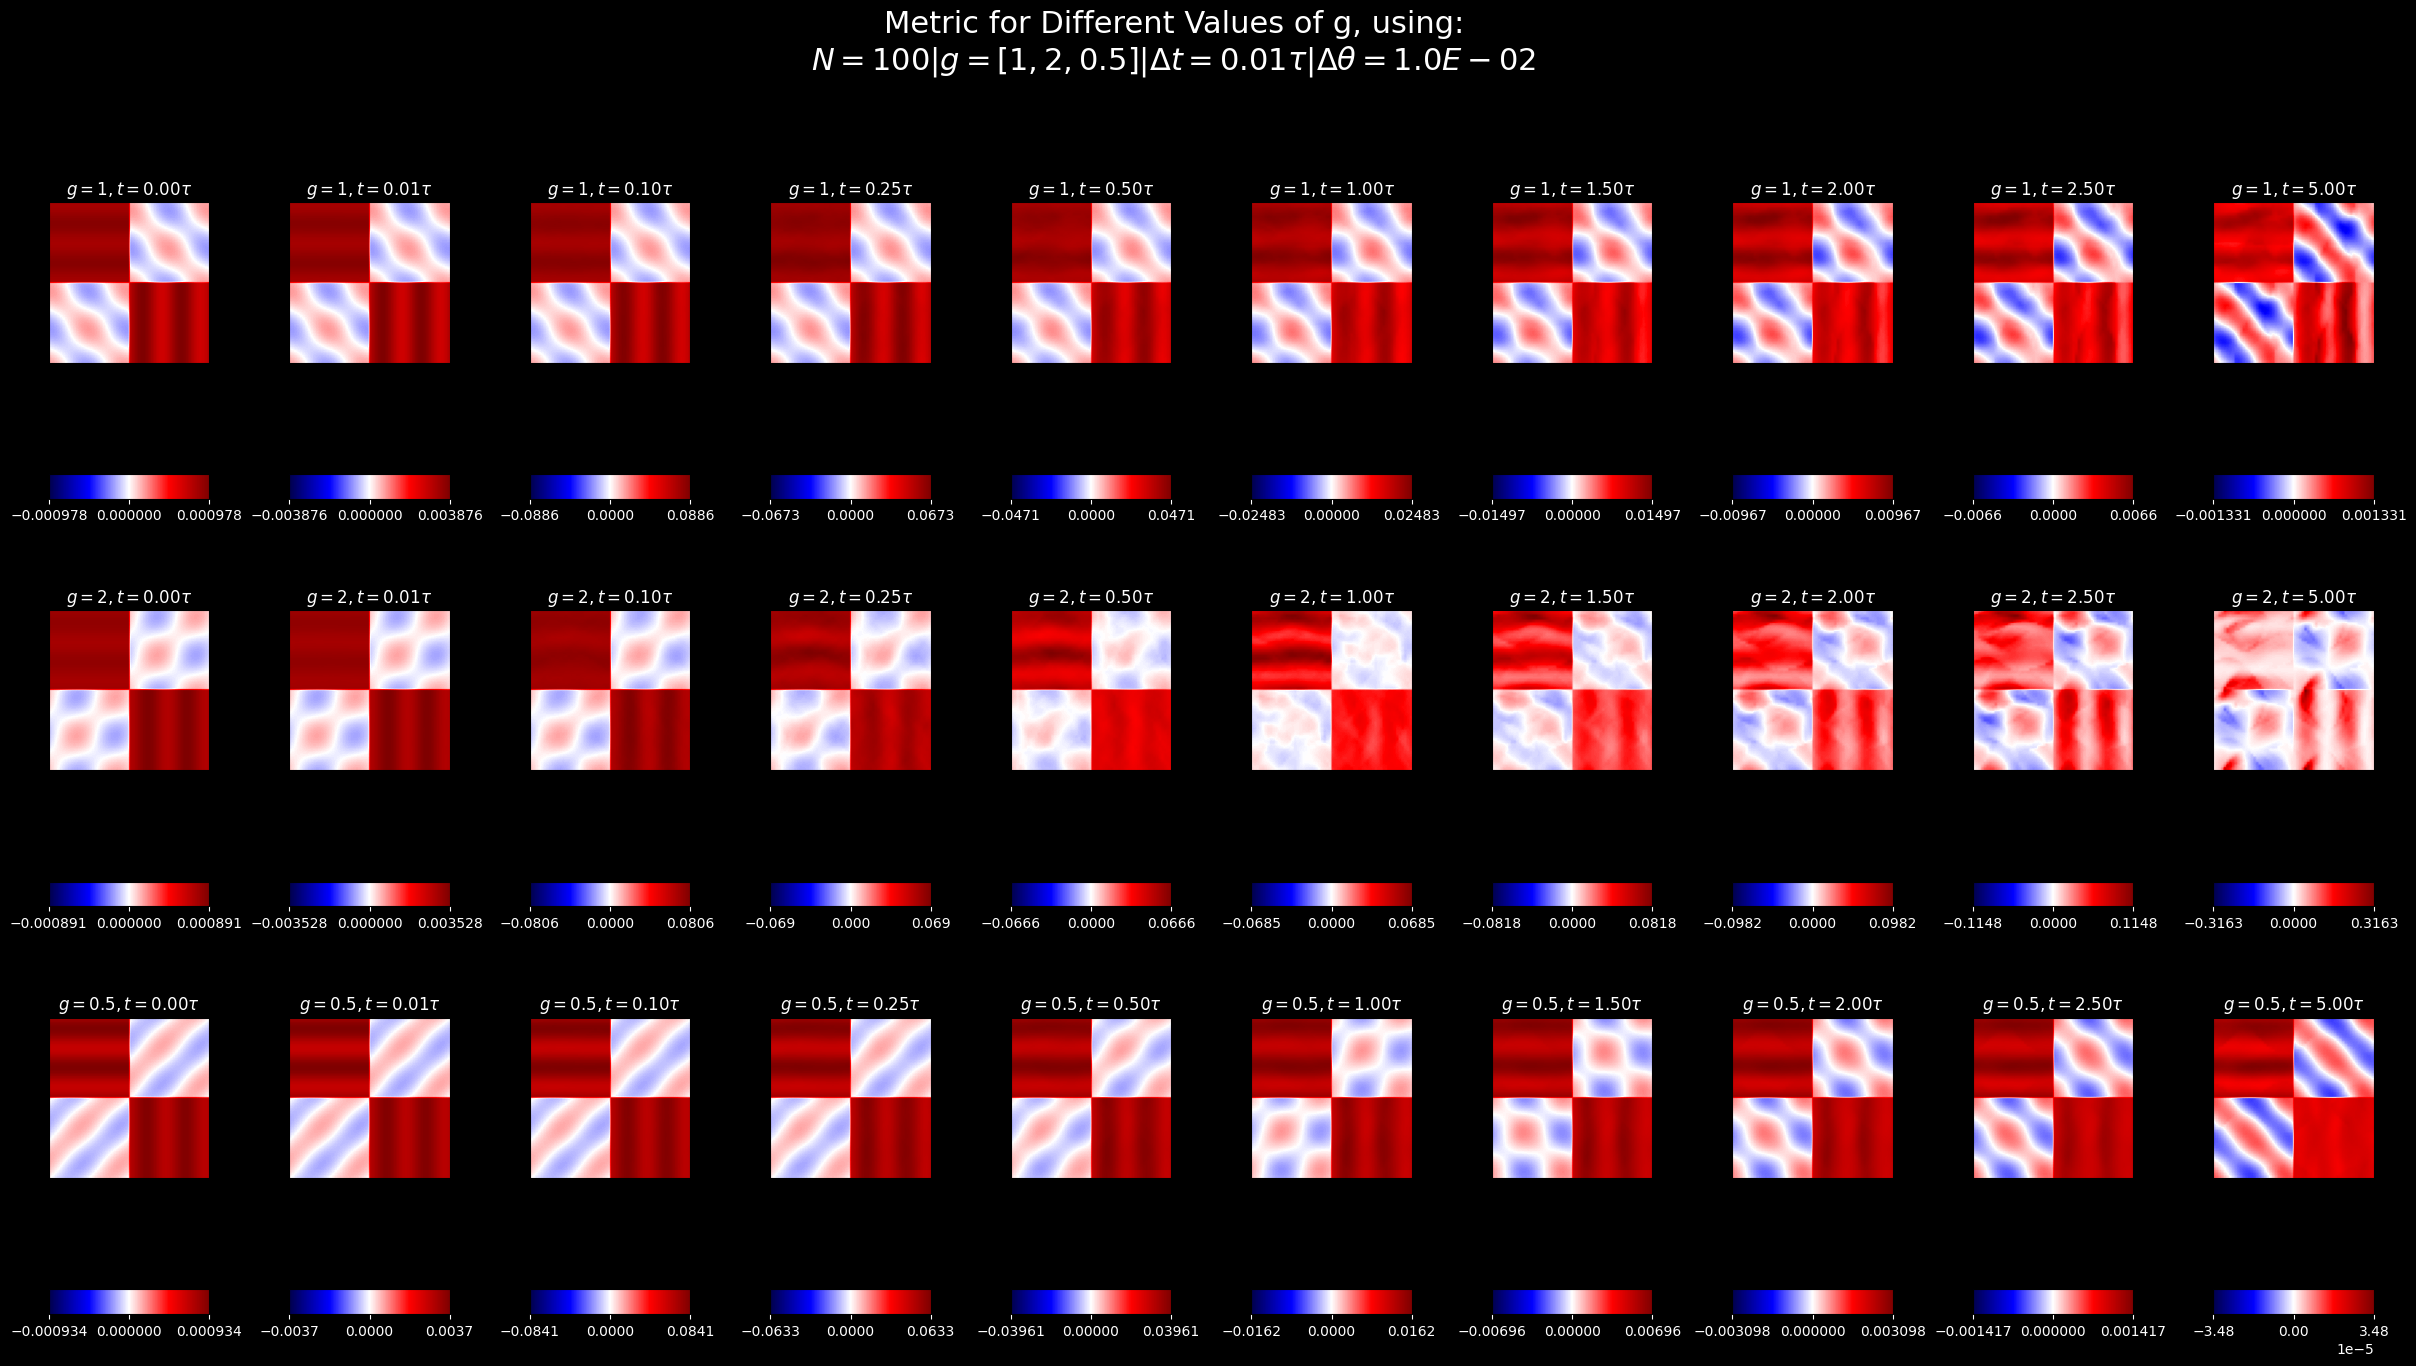

In [99]:
"""
Plot results
"""

fig = plt.figure(figsize=(min(8*len(T), 30), min(5*len(plot_var), 30)))
gs = fig.add_gridspec(2*len(plot_var), len(T), wspace=0.5, hspace=0.5, height_ratios = np.concatenate([[1, 0.1] for _ in range(len(plot_var))]))

for i, v in enumerate(plot_var):
    for j, t in enumerate(T):
        metric_ = all_metrics[i]

        vmax = np.max(np.abs(all_metrics[i][j].numpy()))
        norm = matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax)

        ax = fig.add_subplot(gs[2*i, j])
        im = ax.imshow(metric_[j].numpy(), cmap='seismic', norm=norm)
        ax.set_title(fr"${plot_var_title}={v}, t={t*alpha:.2f}\tau$")
        ax.set_xticks([])
        ax.set_yticks([])

        cax = fig.add_subplot(gs[2*i+1, j])
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
        cax.set_xticks([im.norm.vmin, 0, im.norm.vmax])
    
fig.suptitle(f"Metric for Different Values of {plot_var_title}, using:\n" + fr"$N = {N} | g = {g} | \Delta t={alpha}\tau | \Delta \theta = {d_theta:.1E}$", fontsize=22)

# Comparison with Trained Network

In [13]:
n_samples = 50
T = [0, 1, 10, 25, 50, 100, 150, 200, 250, 500]
alpha = 0.01

### Checking equivalence

In [14]:
def fill_hd_sd_0d_data(inputs, targets, vars):

    batch_size, n_timesteps, init_duration = n_samples**2, max(T)+1, int(1/alpha)

    inputs[:,:,0] = vars['av']
    inputs[:,:init_duration,1] = torch.sin(vars['hd'][:,0]).reshape((batch_size,1)).repeat((1,init_duration))
    inputs[:,:init_duration,2] = torch.cos(vars['hd'][:,0]).reshape((batch_size,1)).repeat((1,init_duration))
    inputs[:,:init_duration,3] = vars['sx'].repeat((1,init_duration))
    inputs[:,:init_duration,4] = vars['sy'].repeat((1,init_duration))

    targets[:,:,0] = torch.sin(vars['hd'])
    targets[:,:,1] = torch.cos(vars['hd'])
    targets[:,:,2] = torch.sin(vars['sd'])
    targets[:,:,3] = torch.cos(vars['sd'])

    return inputs, targets, vars

def create_hd_sd_iso_data(inputs, targets):
    batch_size, n_timesteps, init_duration = n_samples**2, max(T)+1, int(1/alpha)

    n_steps = n_samples
    assert batch_size == n_steps**2

    joint_range = torch.meshgrid(torch.linspace(0, 2*np.pi, n_steps), torch.linspace(0, 2*np.pi, n_steps))
    hd_range, sd_range = joint_range[0].flatten(), joint_range[1].flatten()

    head_direction = hd_range.reshape((batch_size, 1)).repeat((1, n_timesteps))
    ego_shelter_angle = sd_range.reshape((batch_size, 1)).repeat((1, n_timesteps))

    allo_shelter_angle = torch.remainder(head_direction + ego_shelter_angle, 2*np.pi)[:,0].reshape((batch_size,1))

    vars = {'av': torch.zeros((batch_size, n_timesteps)), 
            'hd': head_direction, 
            'sd': ego_shelter_angle,
            'sx': torch.cos(allo_shelter_angle), 
            'sy': torch.sin(allo_shelter_angle)}
    
    return fill_hd_sd_0d_data(inputs, targets, vars)

inputs = torch.zeros((n_samples**2, max(T)+1, 5))
targets = torch.zeros((n_samples**2, max(T)+1, 4)) 
inputs, targets, vars = create_hd_sd_iso_data(inputs, targets)

In [38]:
net_state_dict = torch.load('trained-models/1738685506.4830236-task:HD_SD-0D-optimiser_name:HF-max_lr:0.1-rate_lambda:0.01-weight_lambda:0.01/checkpoint-epochs:19300/net.pt', map_location='cpu')['net_state_dict']

from net import RNN
from Tasks.HD_SD_0D import HD_SD_0D_TASK
net = RNN(HD_SD_0D_TASK)
net.load_state_dict(net_state_dict)
net.tau = 1
net.dt = alpha
net.state_noise_std = net.rate_noise_std = net.output_noise_std = 0

comp_net = Net(n_inputs=4, n_units=100, g=1.5)
comp_net.x_0 = nn.Parameter(net_state_dict['x_0'], requires_grad=False)
comp_net.W_in.weight = nn.Parameter(net_state_dict['W_in.weight'][:,1:], requires_grad=False)
comp_net.W_in.bias = nn.Parameter(net_state_dict['W_in.bias'], requires_grad=False)
comp_net.W_rec.weight = nn.Parameter(net_state_dict['W_rec.weight'], requires_grad=False)

W_out = nn.Linear(100, 4, bias=True)
W_out.weight = nn.Parameter(net_state_dict['W_out.weight'], requires_grad=False)
W_out.bias = nn.Parameter(net_state_dict['W_out.bias'], requires_grad=False)

In [30]:
n_timesteps = max(T)+1
t0 = int(1/alpha)
theta_1_vals = torch.linspace(0, 2*np.pi, n_samples)
theta_2_vals = torch.linspace(0, 2*np.pi, n_samples)

theta_1, theta_2 = torch.meshgrid(theta_1_vals, theta_2_vals)
theta_1, theta_2 = theta_1.flatten(), theta_2.flatten()
theta_3 = torch.remainder(theta_1 + theta_2, 2*np.pi)

# Trained Inputs
inputs, targets = torch.zeros((n_samples**2, n_timesteps, 5)), torch.zeros((n_samples**2, n_timesteps, 4))
inputs, targets, _ = create_hd_sd_iso_data(inputs, targets)

# Computed Inputs
inputs_ = torch.stack([torch.sin(theta_1), torch.cos(theta_1), torch.cos(theta_3), torch.sin(theta_3)], dim=1)
targets_ = torch.stack([torch.sin(theta_1), torch.cos(theta_1), torch.sin(theta_2), torch.cos(theta_2)], dim=1).reshape((n_samples**2, 1, 4)).repeat((1, n_timesteps, 1))


trained_inputs_to_trained_net = inputs
trained_targets_to_trained_net = targets

trained_inputs_to_comp_net = inputs[:,0,1:]
trained_targets_to_comp_net = targets

comp_inputs_to_trained_net = torch.concatenate([
        torch.concatenate([
            torch.zeros((n_samples**2, 1)), inputs_
        ], dim=1).reshape((n_samples**2, 1, 5)).repeat((1, t0, 1)), torch.zeros((n_samples**2, n_timesteps-t0, 5))
    ], dim=1)
comp_targets_to_trained_net = targets_

comp_inputs_to_comp_net = inputs_
comp_targets_to_comp_net = targets_

print(np.isclose(trained_inputs_to_trained_net.numpy(), comp_inputs_to_trained_net.numpy(), atol=1e-6).all())
print(np.isclose(trained_targets_to_trained_net.numpy(), comp_targets_to_trained_net.numpy(), atol=1e-6).all())
print(np.isclose(trained_inputs_to_comp_net.numpy(), comp_inputs_to_comp_net.numpy(), atol=1e-6).all())
print(np.isclose(trained_targets_to_comp_net.numpy(), comp_targets_to_comp_net.numpy(), atol=1e-6).all())



True
True
True
True


In [39]:
with torch.no_grad():
    trained_states_from_trained_inputs,_,trained_outputs_from_trained_inputs = net(trained_inputs_to_trained_net)
    trained_states_from_comp_inputs,_,trained_outputs_from_comp_inputs = net(comp_inputs_to_trained_net)

    comp_states_from_trained_inputs = comp_net(trained_inputs_to_comp_net, n_timesteps=n_timesteps, n_input_times=t0, alpha=alpha, noise_std=0)
    comp_states_from_comp_inputs = comp_net(comp_inputs_to_comp_net, n_timesteps=n_timesteps, n_input_times=t0, alpha=alpha, noise_std=0)

print(np.isclose(trained_states_from_trained_inputs.numpy(), trained_states_from_comp_inputs.numpy(), atol=1e-6).all())
print(np.isclose(comp_states_from_trained_inputs.numpy(), comp_states_from_comp_inputs.numpy(), atol=1e-6).all())

print(np.isclose(trained_states_from_trained_inputs.numpy(), comp_states_from_trained_inputs.numpy(), atol=1e-4).all())
print(np.isclose(trained_states_from_comp_inputs.numpy(), comp_states_from_comp_inputs.numpy(), atol=1e-4).all())

True
True
True
True


In [40]:
comp_outputs_from_trained_inputs = W_out(comp_net.activation_func(comp_states_from_trained_inputs))
comp_outputs_from_comp_inputs = W_out(comp_net.activation_func(comp_states_from_comp_inputs))

print(np.isclose(trained_outputs_from_trained_inputs.numpy(), comp_outputs_from_trained_inputs.numpy(), atol=1e-4).all())
print(np.isclose(trained_outputs_from_comp_inputs.numpy(), comp_outputs_from_comp_inputs.numpy(), atol=1e-4).all())

True
True


In [41]:
trained_loss_from_trained_inputs = nn.MSELoss()(trained_outputs_from_trained_inputs, trained_targets_to_trained_net)
trained_loss_from_comp_inputs = nn.MSELoss()(trained_outputs_from_comp_inputs, comp_targets_to_trained_net)

comp_loss_from_trained_inputs = nn.MSELoss()(comp_outputs_from_trained_inputs, trained_targets_to_comp_net)
comp_loss_from_comp_inputs = nn.MSELoss()(comp_outputs_from_comp_inputs, comp_targets_to_comp_net)

print(trained_loss_from_trained_inputs, trained_loss_from_comp_inputs)
print(comp_loss_from_trained_inputs, comp_loss_from_comp_inputs)

tensor(0.0400) tensor(0.0400)
tensor(0.0400) tensor(0.0400)


In [42]:
del trained_states_from_trained_inputs, trained_states_from_comp_inputs, comp_states_from_trained_inputs, comp_states_from_comp_inputs
del trained_outputs_from_trained_inputs, trained_outputs_from_comp_inputs, comp_outputs_from_trained_inputs, comp_outputs_from_comp_inputs
del trained_loss_from_trained_inputs, trained_loss_from_comp_inputs, comp_loss_from_trained_inputs, comp_loss_from_comp_inputs
gc.collect()

520

## Plotting

In [6]:
alpha = 0.01
T = [0, 9, 49, 99, 199, 499, 999, 2499, 4999, 9999]
n_timesteps = max(T)+1
n_samples = 25
t0 = int(1/alpha)
d_theta = 1e-3
order = 3

theta_1_vals, theta_2_vals = torch.linspace(0, 2*np.pi, n_samples), torch.linspace(0, 2*np.pi, n_samples)

checkpoint_path = 'trained-models/1737566092.4583075-task:HD_SD-0D-rate_lambda:0.01-weight_lambda:0.01/checkpoint-epochs:72000/net.pt'
# checkpoint_path = 'trained-models/1738685506.4830236-task:HD_SD-0D-optimiser_name:HF-max_lr:0.1-rate_lambda:0.01-weight_lambda:0.01/checkpoint-epochs:19300/net.pt'

hd_ad_checkpoint_path = 'trained-models/1740150680.5418458-task:HD_AD-0D/checkpoint-loss:0.04/net.pt'

from task import Task
from net import RNN
from Tasks.HD_SD_0D import HD_SD_0D_TASK
trained_net_task = Task.from_checkpoint(torch.load(checkpoint_path, map_location='cpu'))
trained_net_task.config.device = 'cpu'
untrained_net_original = RNN(trained_net_task)
untrained_net = Net(n_inputs=4, n_units=100)
untrained_net.x_0 = nn.Parameter(untrained_net_original.x_0, requires_grad=False)
untrained_net.W_in.weight = nn.Parameter(untrained_net_original.W_in.weight[:,1:], requires_grad=False)
untrained_net.W_in.bias = nn.Parameter(untrained_net_original.W_in.bias, requires_grad=False)
untrained_net.W_rec.weight = nn.Parameter(untrained_net_original.W_rec.weight, requires_grad=False)

trained_net_state_dict = torch.load(checkpoint_path, map_location='cpu')['net_state_dict']
trained_net = Net(n_inputs=4, n_units=100)
trained_net.x_0 = nn.Parameter(trained_net_state_dict['x_0'], requires_grad=False)
trained_net.W_in.weight = nn.Parameter(trained_net_state_dict['W_in.weight'][:,[1,2,4,3]], requires_grad=False)
trained_net.W_in.bias = nn.Parameter(trained_net_state_dict['W_in.bias'], requires_grad=False)
trained_net.W_rec.weight = nn.Parameter(trained_net_state_dict['W_rec.weight'], requires_grad=False)

from Tasks.HD_AD_0D import HD_AD_0D_TASK
comp_net_task = Task.from_checkpoint(torch.load(hd_ad_checkpoint_path, map_location='cpu'))
comp_net_task.config.device = 'cpu'
comp_net_state_dict = torch.load(hd_ad_checkpoint_path, map_location='cpu')['net_state_dict']
comp_net = Net(n_inputs=4, n_units=100)
comp_net.x_0 = nn.Parameter(comp_net_state_dict['x_0'], requires_grad=False)
comp_net.W_in.weight = nn.Parameter(comp_net_state_dict['W_in.weight'][:,[2,3,5,4]], requires_grad=False)
comp_net.W_in.bias = nn.Parameter(comp_net_state_dict['W_in.bias'], requires_grad=False)
comp_net.W_rec.weight = nn.Parameter(comp_net_state_dict['W_rec.weight'], requires_grad=False)

stable_net = Net(n_inputs=4, n_units=100, g=0.9)

chaotic_net = Net(n_inputs=4, n_units=100, g=2)

def input_func_HD_AD(theta_1, theta_2):
    return torch.stack([torch.sin(theta_1), torch.cos(theta_1), torch.sin(theta_2), torch.cos(theta_2)], dim=1)

def input_func_HD_SD(theta_1, theta_2):
    theta_3 = torch.remainder(theta_1 + theta_2, 2*np.pi)
    return torch.stack([torch.sin(theta_1), torch.cos(theta_1), torch.cos(theta_3), torch.sin(theta_3)], dim=1)

trained_HD_AD_dphi_dtheta_1, trained_HD_AD_dphi_dtheta_2 = get_dphi_dtheta(theta_1_vals, theta_2_vals, trained_net, input_func_HD_AD, n_timesteps=max(T)+1, alpha=alpha, noise_std=0, d_theta=d_theta, n_input_times=t0, order=order, select_t=T)
trained_HD_AD_metric = get_metric(trained_HD_AD_dphi_dtheta_1, trained_HD_AD_dphi_dtheta_2)

untrained_HD_AD_dphi_dtheta_1, untrained_HD_AD_dphi_dtheta_2 = get_dphi_dtheta(theta_1_vals, theta_2_vals, untrained_net, input_func_HD_AD, n_timesteps=max(T)+1, alpha=alpha, noise_std=0, d_theta=d_theta, n_input_times=t0, order=order, select_t=T)
untrained_HD_AD_metric = get_metric(untrained_HD_AD_dphi_dtheta_1, untrained_HD_AD_dphi_dtheta_2)

comp_HD_AD_dphi_dtheta_1, comp_HD_AD_dphi_dtheta_2 = get_dphi_dtheta(theta_1_vals, theta_2_vals, comp_net, input_func_HD_AD, n_timesteps=max(T)+1, alpha=alpha, noise_std=0, d_theta=d_theta, n_input_times=t0, order=order, select_t=T)
comp_HD_AD_metric = get_metric(comp_HD_AD_dphi_dtheta_1, comp_HD_AD_dphi_dtheta_2)

stable_HD_AD_dphi_dtheta_1, stable_HD_AD_dphi_dtheta_2 = get_dphi_dtheta(theta_1_vals, theta_2_vals, stable_net, input_func_HD_AD, n_timesteps=max(T)+1, alpha=alpha, noise_std=0, d_theta=d_theta, n_input_times=t0, order=order, select_t=T)
stable_HD_AD_metric = get_metric(stable_HD_AD_dphi_dtheta_1, stable_HD_AD_dphi_dtheta_2)

chaotic_HD_AD_dphi_dtheta_1, chaotic_HD_AD_dphi_dtheta_2 = get_dphi_dtheta(theta_1_vals, theta_2_vals, chaotic_net, input_func_HD_AD, n_timesteps=max(T)+1, alpha=alpha, noise_std=0, d_theta=d_theta, n_input_times=t0, order=order, select_t=T)
chaotic_HD_AD_metric = get_metric(chaotic_HD_AD_dphi_dtheta_1, chaotic_HD_AD_dphi_dtheta_2)



# trained_HD_SD_dphi_dtheta_1, trained_HD_SD_dphi_dtheta_2 = get_dphi_dtheta(theta_1_vals, theta_2_vals, comp_net, input_func_HD_SD, n_timesteps=max(T)+1, alpha=alpha, noise_std=0, d_theta=d_theta, n_input_times=t0, order=order, select_t=T)
# trained_HD_SD_metric = get_metric(trained_HD_SD_dphi_dtheta_1, trained_HD_SD_dphi_dtheta_2)

# untrained_HD_SD_dphi_dtheta_1, untrained_HD_SD_dphi_dtheta_2 = get_dphi_dtheta(theta_1_vals, theta_2_vals, untrained_net, input_func_HD_SD, n_timesteps=max(T)+1, alpha=alpha, noise_std=0, d_theta=d_theta, n_input_times=t0, order=order, select_t=T)
# untrained_HD_SD_metric = get_metric(untrained_HD_SD_dphi_dtheta_1, untrained_HD_SD_dphi_dtheta_2)

# random_HD_SD_dphi_dtheta_1, random_HD_SD_dphi_dtheta_2 = get_dphi_dtheta(theta_1_vals, theta_2_vals, random_net, input_func_HD_SD, n_timesteps=max(T)+1, alpha=alpha, noise_std=0, d_theta=d_theta, n_input_times=t0, order=order, select_t=T)
# random_HD_SD_metric = get_metric(random_HD_SD_dphi_dtheta_1, random_HD_SD_dphi_dtheta_2)

dict_keys(['HD_SD-0D'])
dict_keys(['HD_SD-0D', 'HD_AD-0D'])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.98, 'Metric for Different Networks, using:\n$\\Delta t=0.01\\tau | \\Delta \\theta = 1.0E-03$ | Order 3')

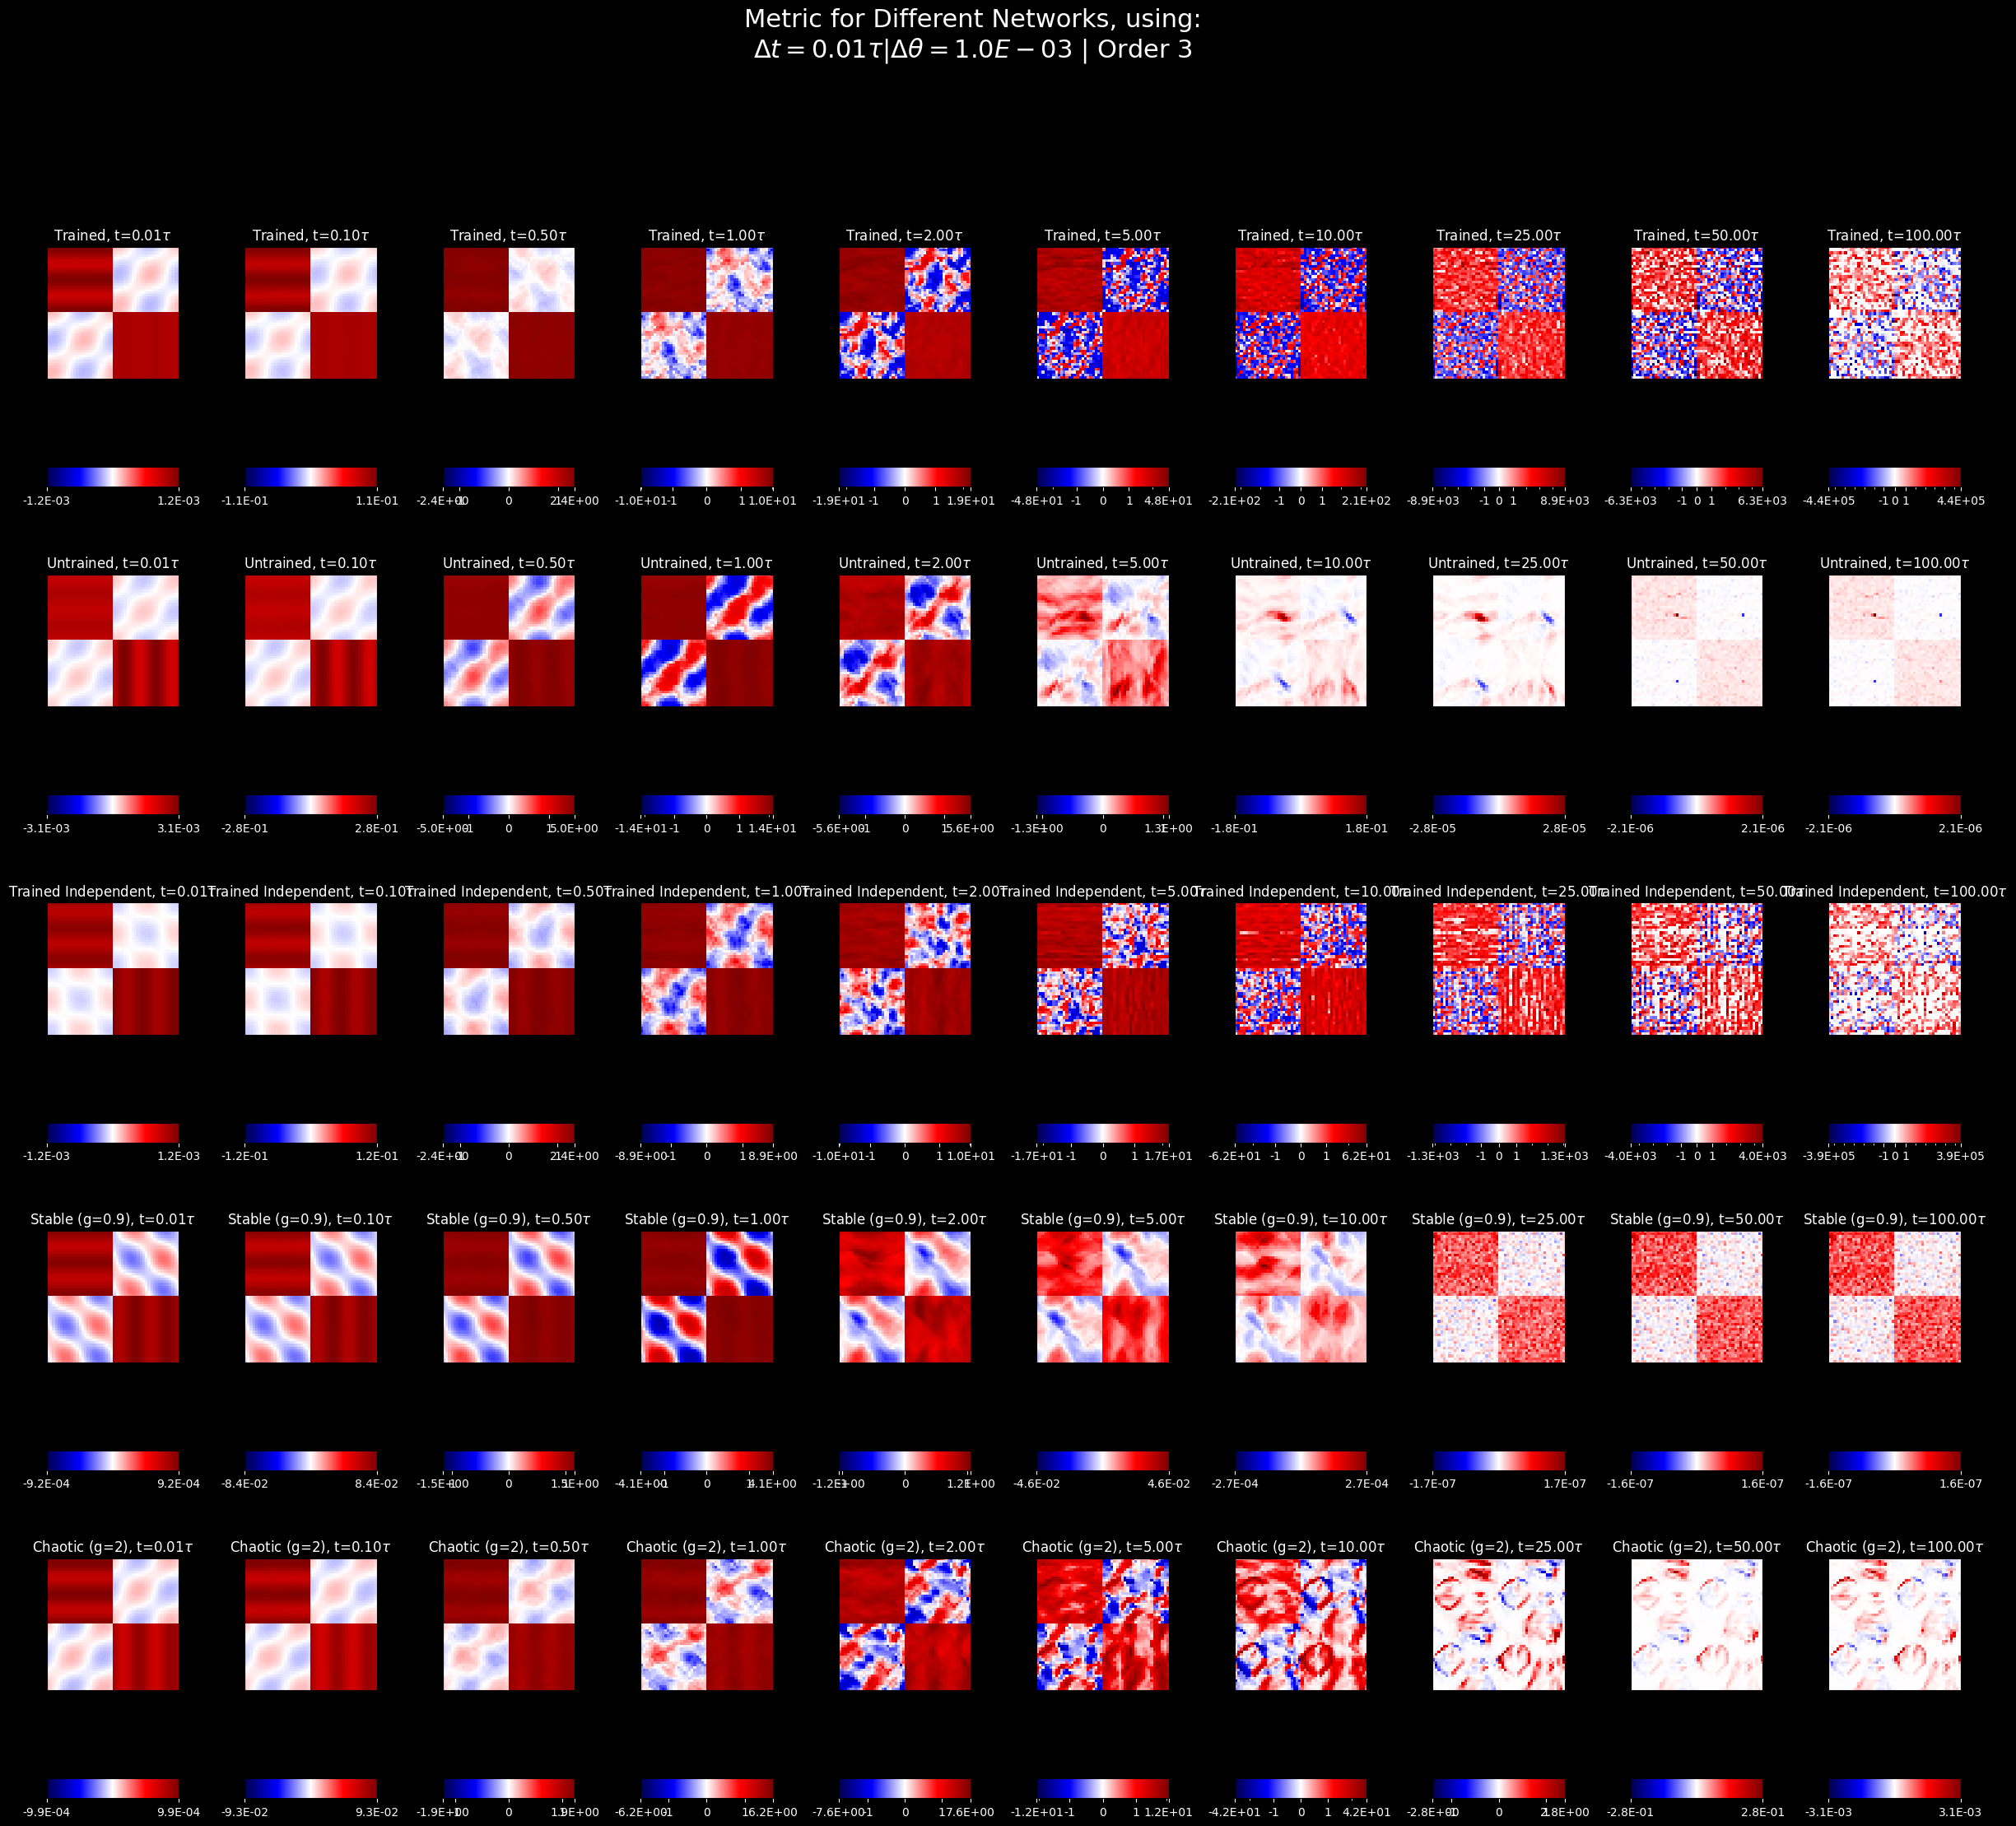

In [7]:
all_metrics = [trained_HD_AD_metric, untrained_HD_AD_metric, comp_HD_AD_metric, stable_HD_AD_metric, chaotic_HD_AD_metric]#, trained_HD_SD_metric, untrained_HD_SD_metric, random_HD_SD_metric]
names = ['Trained', 'Untrained', 'Trained Independent', 'Stable (g=0.9)', 'Chaotic (g=2)']#, 'Trained HD-SD', 'Untrained HD-SD', 'Random HD-SD']

fig = plt.figure(figsize=(min(8*len(T), 30), min(5*len(all_metrics), 30)))
gs = fig.add_gridspec(2*len(all_metrics), len(T), wspace=0.5, hspace=0.5, height_ratios = np.concatenate([[1, 0.1] for _ in range(len(all_metrics))]))

for i, (metric,  name) in enumerate(zip(all_metrics, names)):
    for j, t in enumerate(T):
        metric_ = metric[j].numpy()

        if np.max(np.abs(metric_)) < 1:
            norm = matplotlib.colors.Normalize(vmin=-np.max(np.abs(metric_)), vmax=np.max(np.abs(metric_)))
        else:
            norm = matplotlib.colors.SymLogNorm(linthresh=1, vmin=-np.max(np.abs(metric_)), vmax=np.max(np.abs(metric_)))

        ax = fig.add_subplot(gs[2*i, j])
        im = ax.imshow(metric_, cmap='seismic', norm=norm)
        ax.set_title(f"{name}, t={(t+1)*alpha:.2f}" + r"$\tau$")
        ax.set_xticks([])
        ax.set_yticks([])

        cax = fig.add_subplot(gs[2*i+1, j])
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
        if im.norm.vmin < -1 and im.norm.vmax > 1:
            cax.set_xticks([im.norm.vmin, -1,0,1, im.norm.vmax])
            cax.set_xticklabels([f"{im.norm.vmin:.1E}", '-1','0','1', f"{im.norm.vmax:.1E}"])
        else:
            cax.set_xticks([im.norm.vmin, im.norm.vmax])
            cax.set_xticklabels([f"{im.norm.vmin:.1E}", f"{im.norm.vmax:.1E}"])

fig.suptitle(f"Metric for Different Networks, using:\n" + fr"$\Delta t={alpha}\tau | \Delta \theta = {d_theta:.1E}$ | Order {order}", fontsize=22)

In [34]:
alpha = 0.01
T = [0, 9, 49, 99, 199, 499, 999, 2499, 9999]
n_timesteps = max(T)+1
n_samples = 25
t0 = int(1/alpha)
d_theta = 1e-3
order = 3

plot_epochs = 10

theta_1_vals, theta_2_vals = torch.linspace(0, 2*np.pi, n_samples), torch.linspace(0, 2*np.pi, n_samples)

# checkpoint_path = 'trained-models/1737566092.4583075-task:HD_SD-0D-rate_lambda:0.01-weight_lambda:0.01/checkpoint-epochs:72000/net.pt'
checkpoint_path = 'trained-models/1738685506.4830236-task:HD_SD-0D-optimiser_name:HF-max_lr:0.1-rate_lambda:0.01-weight_lambda:0.01/checkpoint-epochs:19300/net.pt'

import os
checkpoint_epochs = []
build_path = '/'.join(checkpoint_path.split('/')[:-2])
for checkpoint_dir in os.listdir(build_path):
    if os.path.isdir(os.path.join(build_path, checkpoint_dir)) and 'epochs' in checkpoint_dir:
        n_epochs = int(checkpoint_dir.split('epochs:')[-1])
        checkpoint_epochs.append(n_epochs)
checkpoint_epochs = np.sort(np.array(checkpoint_epochs))
print(checkpoint_epochs)


def input_func_HD_AD(theta_1, theta_2):
    return torch.stack([torch.sin(theta_1), torch.cos(theta_1), torch.sin(theta_2), torch.cos(theta_2)], dim=1)

early_i = 10
select_epochs = np.concatenate((checkpoint_epochs[np.linspace(0, early_i-1, plot_epochs//2, dtype=np.int32)], checkpoint_epochs[np.linspace(early_i, len(checkpoint_epochs)-1, plot_epochs//2, dtype=np.int32)]))
epoch_metrics = []
for epoch in select_epochs:
    trained_net_state_dict = torch.load(os.path.join(build_path, f'checkpoint-epochs:{epoch}', 'net.pt'), map_location='cpu')['net_state_dict']
    trained_net = Net(n_inputs=4, n_units=100)
    trained_net.x_0 = nn.Parameter(trained_net_state_dict['x_0'], requires_grad=False)
    trained_net.W_in.weight = nn.Parameter(trained_net_state_dict['W_in.weight'][:,[1,2,4,3]], requires_grad=False)
    trained_net.W_in.bias = nn.Parameter(trained_net_state_dict['W_in.bias'], requires_grad=False)
    trained_net.W_rec.weight = nn.Parameter(trained_net_state_dict['W_rec.weight'], requires_grad=False)

    trained_HD_AD_dphi_dtheta_1, trained_HD_AD_dphi_dtheta_2 = get_dphi_dtheta(theta_1_vals, theta_2_vals, trained_net, input_func_HD_AD, n_timesteps=max(T)+1, alpha=alpha, noise_std=0, d_theta=d_theta, n_input_times=t0, order=order, select_t=T)
    trained_HD_AD_metric = get_metric(trained_HD_AD_dphi_dtheta_1, trained_HD_AD_dphi_dtheta_2)
    epoch_metrics.append(trained_HD_AD_metric)

    print(f"Finished Epoch {epoch}")

[  100   200   300   400   500   600   700   800   900  1000  1100  1200
  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400
  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600
  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800
  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000
  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200
  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400
  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600
  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700 10800
 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000
 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200
 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400
 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600
 15700 15800 15900 16000 16100 16200 16300 16400 16

Text(0.5, 0.98, 'Metric for Different Training Epochs, using:\n$\\Delta t=0.01\\tau | \\Delta \\theta = 1.0E-03$ | Order 3')

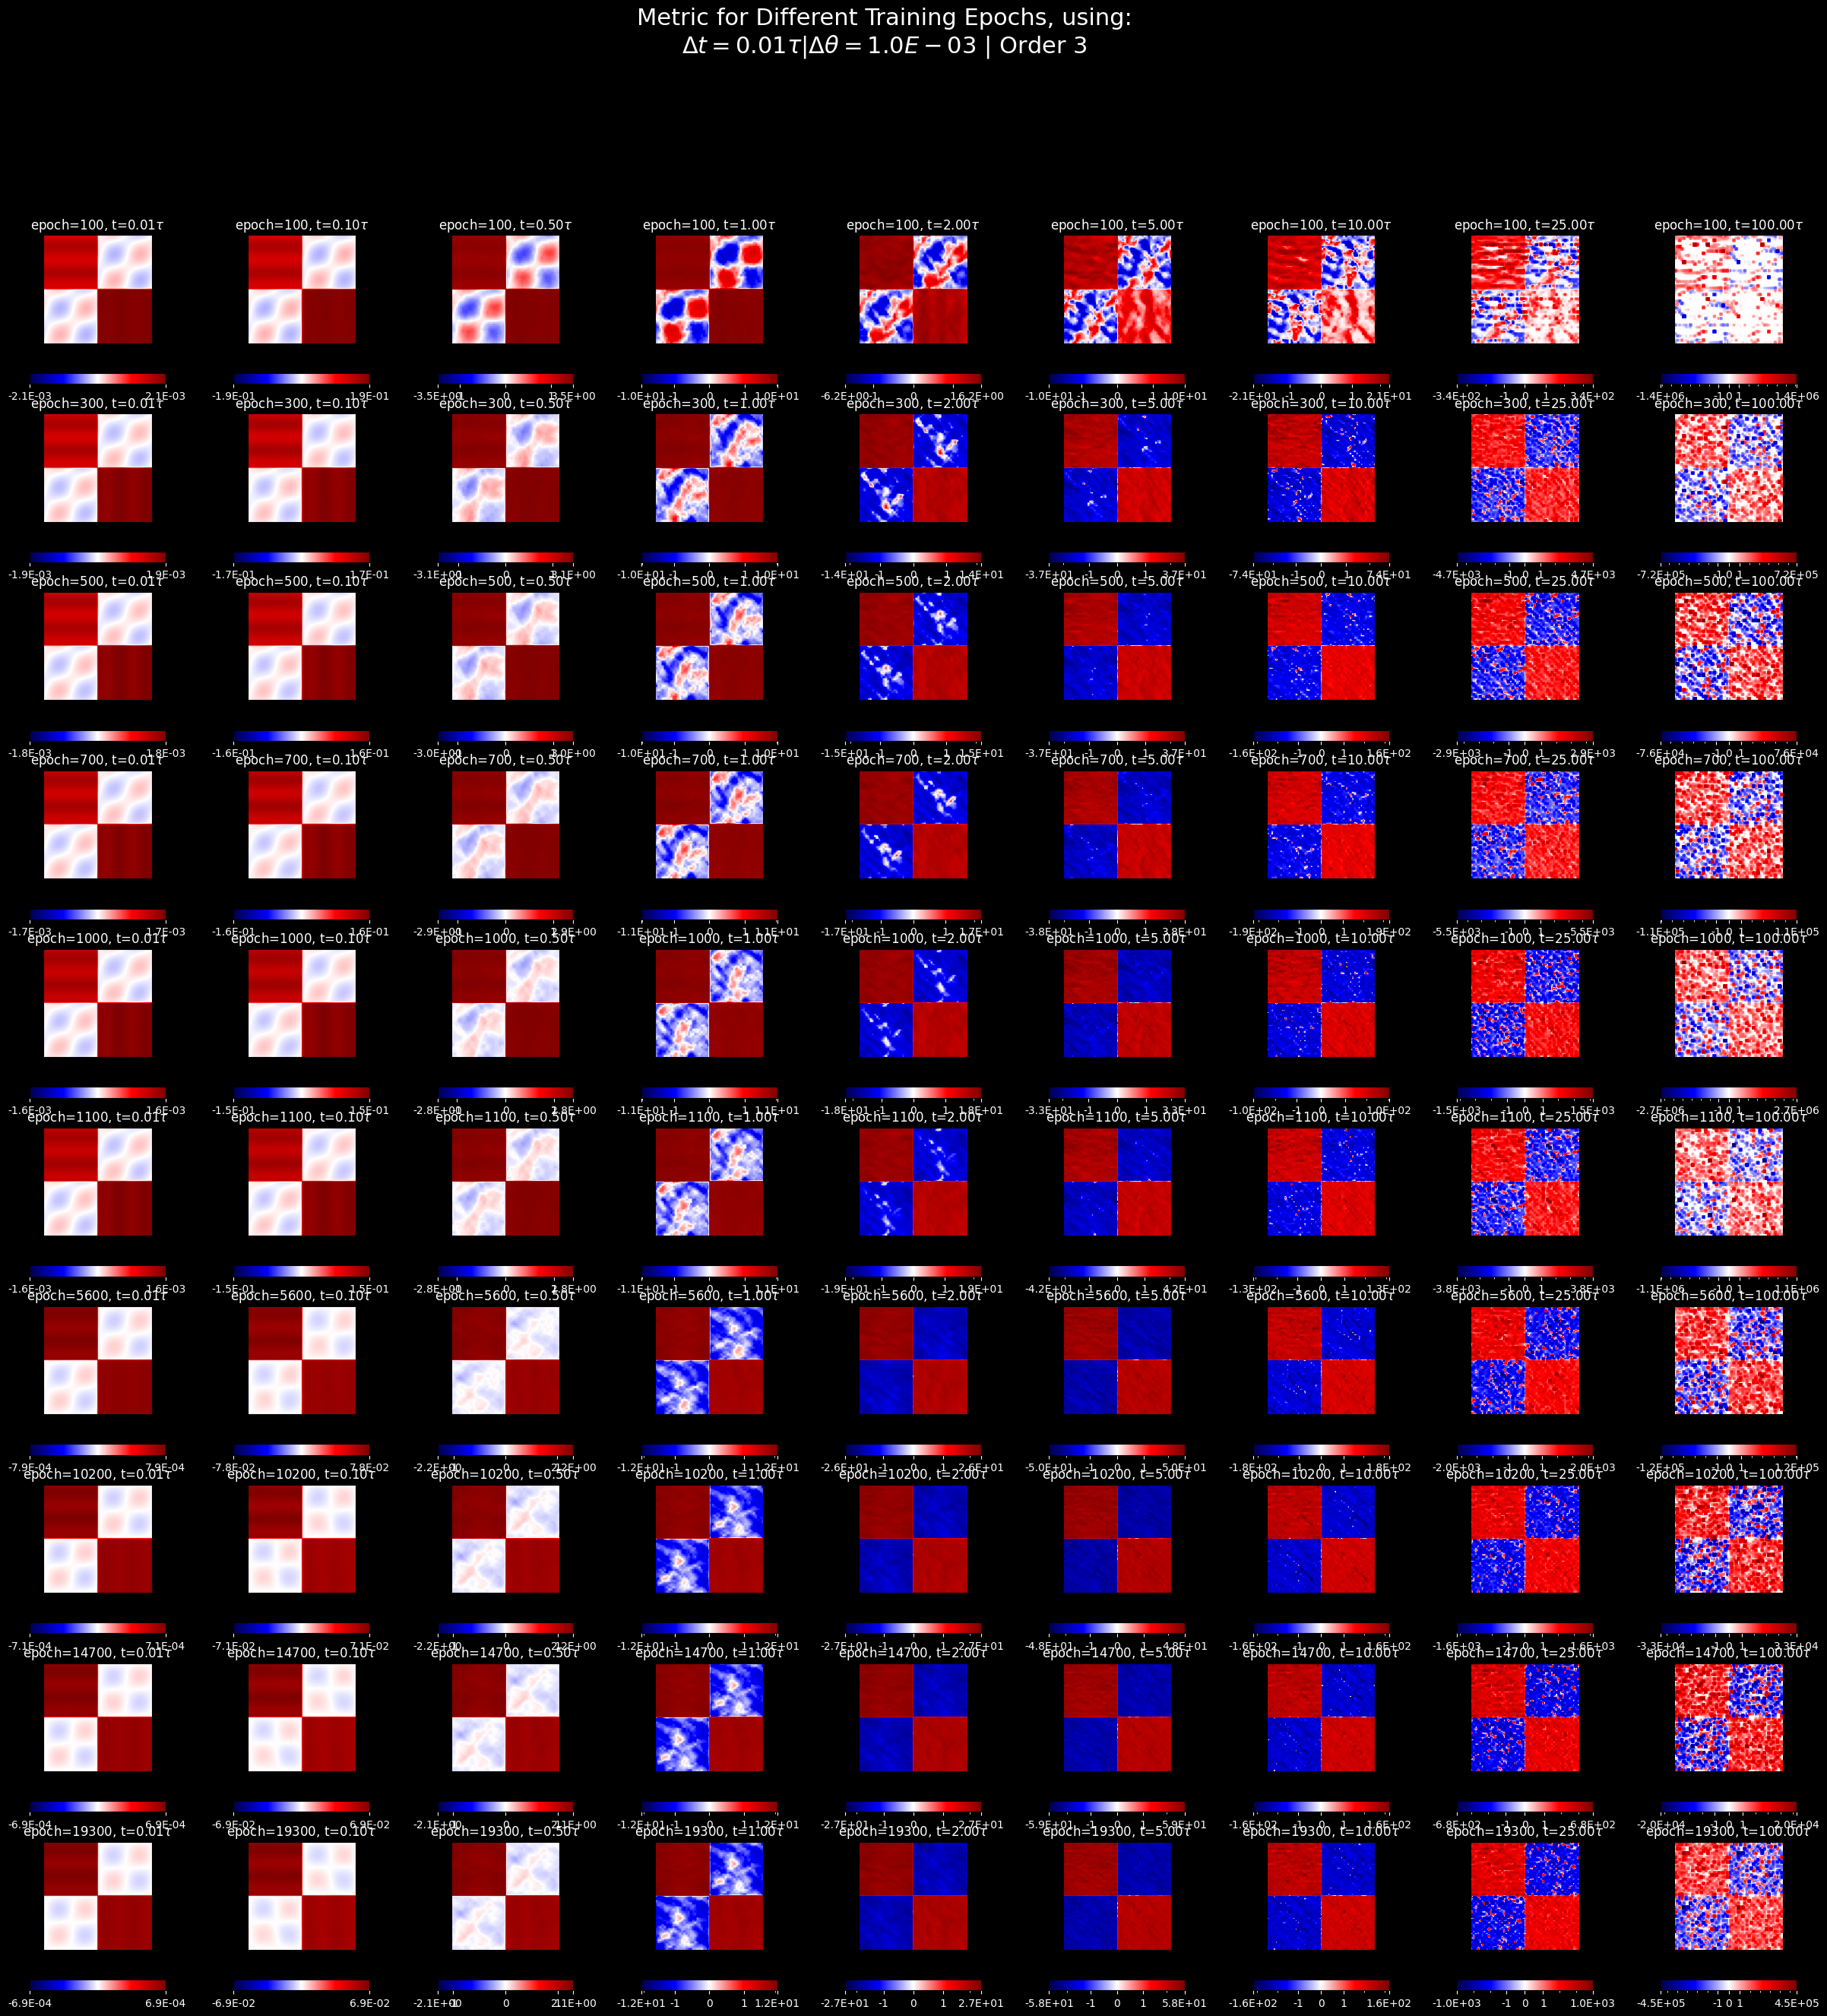

In [36]:
fig = plt.figure(figsize=(min(8*len(T), 30), min(5*len(epoch_metrics), 30)))
gs = fig.add_gridspec(2*len(epoch_metrics), len(T), wspace=0.5, hspace=0.5, height_ratios = np.concatenate([[1, 0.1] for _ in range(len(epoch_metrics))]))

for i, (epoch, metric) in enumerate(zip(select_epochs, epoch_metrics)):
    for j, t in enumerate(T):
        metric_ = metric[j].numpy()

        if np.max(np.abs(metric_)) < 1:
            norm = matplotlib.colors.Normalize(vmin=-np.max(np.abs(metric_)), vmax=np.max(np.abs(metric_)))
        else:
            norm = matplotlib.colors.SymLogNorm(linthresh=1, vmin=-np.max(np.abs(metric_)), vmax=np.max(np.abs(metric_)))

        ax = fig.add_subplot(gs[2*i, j])
        im = ax.imshow(metric_, cmap='seismic', norm=norm)
        ax.set_title(f"epoch={epoch}, t={(t+1)*alpha:.2f}" + r"$\tau$")
        ax.set_xticks([])
        ax.set_yticks([])

        cax = fig.add_subplot(gs[2*i+1, j])
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
        if im.norm.vmin < -1 and im.norm.vmax > 1:
            cax.set_xticks([im.norm.vmin, -1,0,1, im.norm.vmax])
            cax.set_xticklabels([f"{im.norm.vmin:.1E}", '-1','0','1', f"{im.norm.vmax:.1E}"])
        else:
            cax.set_xticks([im.norm.vmin, im.norm.vmax])
            cax.set_xticklabels([f"{im.norm.vmin:.1E}", f"{im.norm.vmax:.1E}"])

fig.suptitle(f"Metric for Different Training Epochs, using:\n" + fr"$\Delta t={alpha}\tau | \Delta \theta = {d_theta:.1E}$ | Order {order}", fontsize=22)